In [1]:
import fcsparser as fcs
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
import scipy.stats as stats
from scipy.optimize import curve_fit
from socket import gethostname

sns.set(style="white")
sns.set_context("notebook")

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

tick_setup = {'labelsize' : SMALL_SIZE,
              'major.pad': 0}

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', **tick_setup)    # fontsize of the tick labels
plt.rc('ytick', **tick_setup)
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

hostname = gethostname().split('.')[0]
if hostname == 'Pluripa':
    home_dir = "/Users/weinberz/"
    box_dir = "/Users/weinberz/Box Sync/"
else:
    home_dir = "/Volumes/Coatamer/Users/weinberz/"
    box_dir = "/Volumes/Coatamer/Users/weinberz/Box/"

def gate_density (df, threshold, y_var='FSC-A', x_var='SSC-A'):
    
    ymin = df[y_var].min()
    ymax = df[y_var].max()
    xmin = df[x_var].min()
    xmax = df[x_var].max()
                                                                                                                                
    #Perform a kernel density estimate on the data:
    df_mini = df.sample(1000)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([df_mini[x_var], df_mini[y_var]])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    cut = Z.max()*threshold
    
    # threhold dataframe
    df['gate'] = kernel([df[x_var], df[y_var]])
    df2 = df[df.gate > cut]
    return df2

In [2]:
outputdir = home_dir + "Google Drive/HES Lab/SARSNotch/SARSNotch Manuscript/jupyter_out/"

In [3]:
folder= box_dir + "VEGAS-MTK/Flow/20210315 - BHK21 with Spike and Cells/"

In [4]:
ffolderlist = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

df=pd.DataFrame()
aa=1
    #load all fcs files
for fdn in ffolderlist:
    ffilelist = os.listdir(folder+fdn)
    for fn in ffilelist:
        filename, file_ext = os.path.splitext(fn)
        if file_ext ==".fcs":
            path = folder + fdn + "//" + fn
            meta, df1 = fcs.parse(path, meta_data_only=False, reformat_meta=True)
            df1["WellName"]=fn.split("_")[3].split(".")[0]
            df1["WellNumber"]= aa
            df=df.append(df1)
            aa=aa+1

# metadata file
meta = folder+ "metadata.csv"
df1=pd.read_csv(meta, names=["WellName", "Receiver","Sender", "Dose", 'Replicate'])

df=df1.merge(df, on=["WellName"])

In [5]:
#remove small events
df2 =df[df["FSC-A"]>5E4]
df2 =df2[df2["SSC-A"]>2.5E4]
df2 =df2[df2["SSC-A"]<2.5E5]
df2 =df2[df2["FSC-A"]<2.5E5]

#remove NAs
df2= df2.loc[(df2.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

#gate cells
df2 = gate_density(df2, 0.1)

#log data
for col in df2.columns:
    if df2[col].dtype=="float32":
        df2["log"+ col]=df2[col].apply(math.log10)

In [16]:
df2.loc[df2['Receiver'] == 'LCB1-Notch', 'Receiver'] = 'SARSNotch'

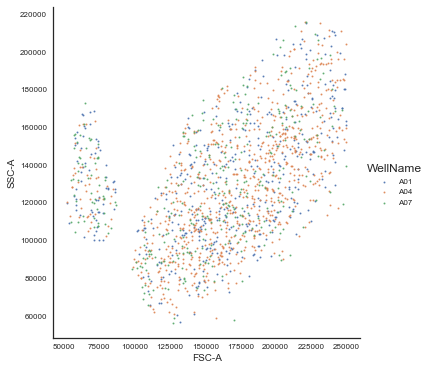

In [7]:
#Visualize populations for Jurkats (well B01) and K562s (well A02) post gating
sns.lmplot(y="SSC-A", x="FSC-A", data=df2[df2["WellName"].isin(['A01', 'A04','A07'])], hue='WellName', fit_reg=False, scatter_kws={'s': 1})
plt.show()

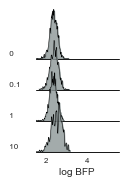

In [49]:
with sns.color_palette(["#8C9696"]):
    g = sns.FacetGrid(data=df2[(df2['Receiver'] == 'No Notch') &
                               (df2['Sender'] == 'None') &
                               (df2['logFITC-A'] > 5)],
                      row='Dose', sharey=False, aspect=2.5, height=0.65, 
                      row_order = [str(x) for x in [0,0.1,1,10]],
                      hue_order = [str(x) for x in [0,0.1,1,10]], xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    for ax in g.axes.flat:
        dose = ax.get_title().split("=")[1]
        ax.text(-0.35,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("log BFP")
    plt.savefig(outputdir+'bhk_no-notch_spike_histogram.svg')

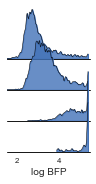

In [48]:
with sns.color_palette(["#4272B8"]):
    g = sns.FacetGrid(data=df2[(df2['Receiver'] == 'SARSNotch') &
                               (df2['Sender'] == 'None') &
                               (df2['logFITC-A'] > 5)],
                      row='Dose', sharey=False, aspect=2.5, height=0.65, 
                      row_order = [str(x) for x in [0,0.1,1,10]],
                      hue_order = [str(x) for x in [0,0.1,1,10]], xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    for ax in g.axes.flat:
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("log BFP")
    plt.savefig(outputdir+'bhk_sarsnotch_spike_histogram.svg')

In [15]:
notch

'SARSNotch'

Text(0, 0.5, 'Fraction in second component')

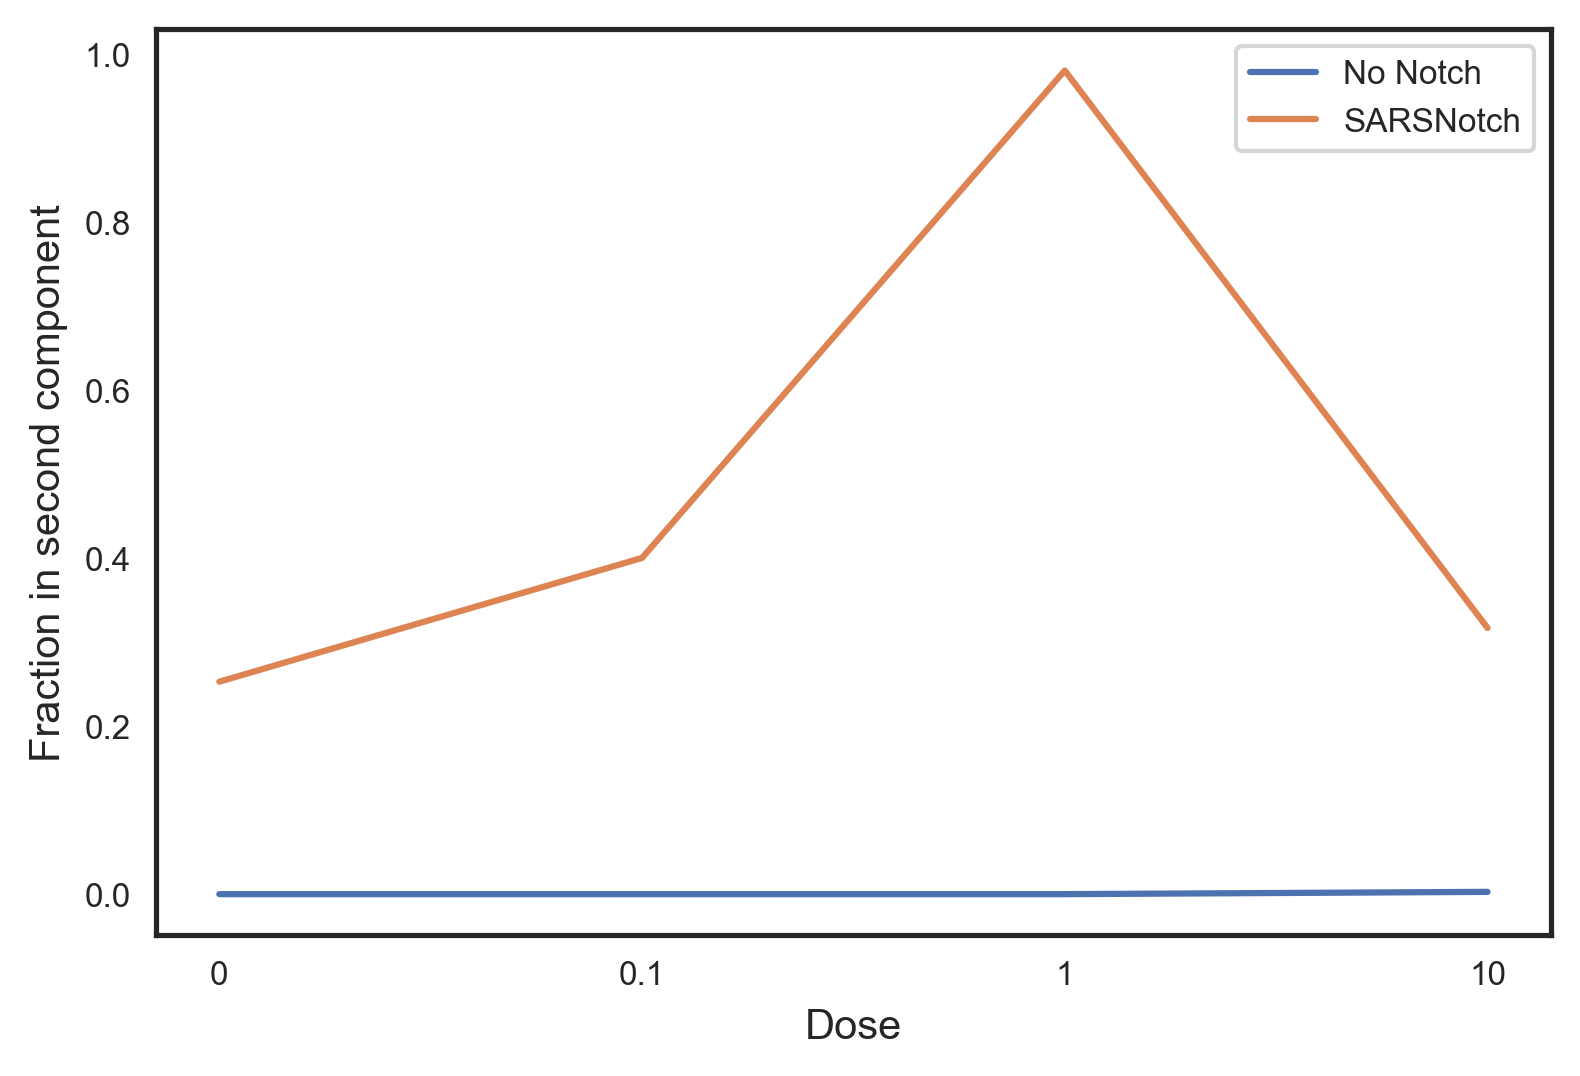

In [78]:
doses = [str(x) for x in [0, 0.1, 1, 10]]
xs = {'No Notch' : [], 'SARSNotch': []}
for dose in [str(x) for x in [0, 0.1, 1, 10]]:
    for notch in ['No Notch', 'SARSNotch']:
        df_ = df2[(df2['Receiver'] == notch) &
              (df2['Dose'] == dose) &
              (df2['logFITC-A'] > 2)].copy()
        dist = df_['logBV 421-A']
        model = GaussianMixture(2, covariance_type='full', means_init=[[2.2],[5]], max_iter=1000, tol=1e-3).fit(dist[:,np.newaxis])
        xs[notch].append(model.weights_[1])
        
plt.figure(dpi=300)
plt.plot(doses, xs['No Notch'], label='No Notch')
plt.plot(doses, xs['SARSNotch'], label='SARSNotch')
plt.xlabel('Dose')
plt.legend()
plt.ylabel('Fraction in second component')

In [45]:
qt = 3.5
summary = (df2[~(df2.Dose == 'None')&
               (df2['logFITC-A'] > 5)].groupby(['Receiver', 'Dose', 'Replicate'])['logBV 421-A']
              .apply(lambda x: 100*np.sum(x>qt)/len(x))
              .reset_index())
summary['Dose'] = pd.to_numeric(summary['Dose'])

<ipython-input-46-d75855c714e0>:7: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('symlog', linthreshx=0.1)


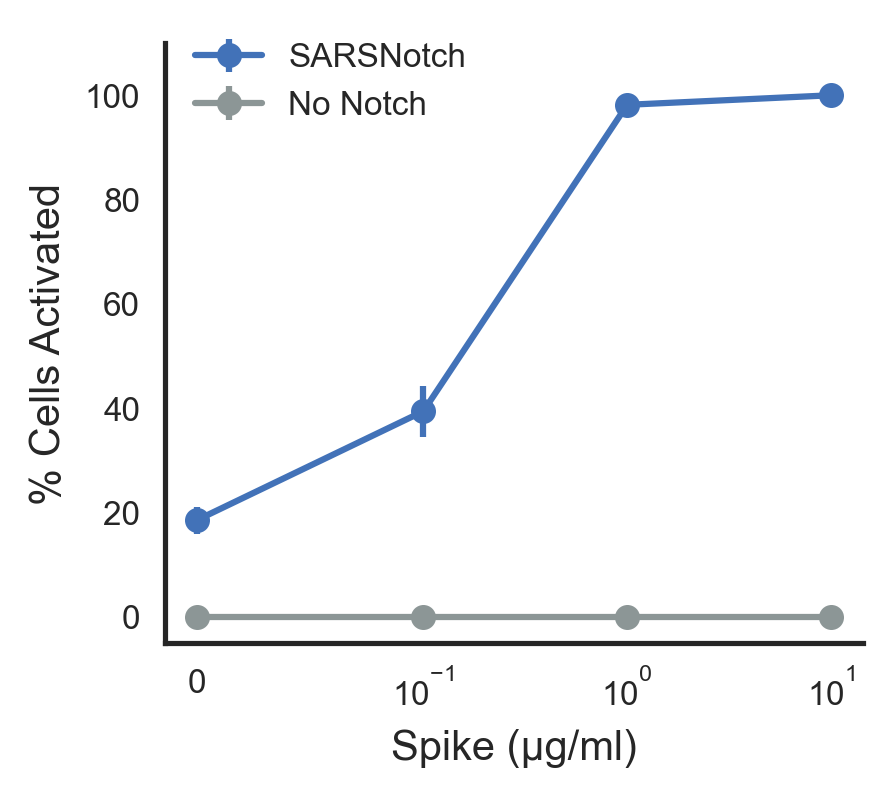

In [46]:
fig, ax = plt.subplots(1,1,figsize=(3,2.65), dpi=300)
for notch, color in zip(['No Notch', 'SARSNotch'],['#8C9696','#4272B8']):
    notch_summary = summary[(summary['Receiver']==notch)]
    output = notch_summary.groupby('Dose')['logBV 421-A'].agg([np.mean, np.std]).reset_index()
    ax.errorbar(output['Dose'], output['mean'], yerr=output['std'], fmt='-',marker='.', markersize=10, c=color, label=notch)

ax.set_xscale('symlog', linthreshx=0.1)
ax.set_xlabel('Spike (µg/ml)')
ax.set_ylabel('% Cells Activated')
order = [1, 0]
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylim([-5,110])
sns.despine()
plt.savefig(outputdir+'bhk_spike_dr.svg')

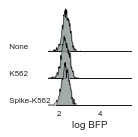

In [54]:
with sns.color_palette(["#8C9696"]):
    g = sns.FacetGrid(data=df2[(df2['logFITC-A'] > 5) & ~(df2.Dose.isin(['0.1','1', '10'])) & (df2['Receiver'] == 'No Notch')],
                      row='Sender', sharey=False, aspect=2.5, height=0.65, 
                      row_order = ['None', 'K562', 'Spike-K562'],
                      hue_order = ['None', 'K562', 'Spike-K562'], xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    for ax in g.axes.flat:
        dose = ax.get_title().split("=")[1]
        ax.text(-0.5,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("log BFP")
    plt.savefig(outputdir+'bhk_no-notch_k562_histogram.svg')

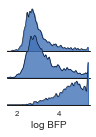

In [53]:
with sns.color_palette(["#4272B8"]):
    g = sns.FacetGrid(data=df2[(df2['logFITC-A'] > 5) & ~(df2.Dose.isin(['0.1','1', '10'])) & (df2['Receiver'] == 'SARSNotch')],
                      row='Sender', sharey=False, aspect=2.5, height=0.65, 
                      row_order = ['None', 'K562', 'Spike-K562'],
                      hue_order = ['None', 'K562', 'Spike-K562'], xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    for ax in g.axes.flat:
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("log BFP")
    plt.savefig(outputdir+'bhk_sarsnotch_k562_histogram.svg')

In [27]:
qt = 3.5
summary = (df2[~(df2.Dose.isin(['0.1','1', '10']))&
               (df2['logFITC-A'] > 5)].groupby(['Receiver', 'Sender', 'Replicate'])['logBV 421-A']
              .apply(lambda x: 100*np.sum(x>qt)/len(x))
              .reset_index())

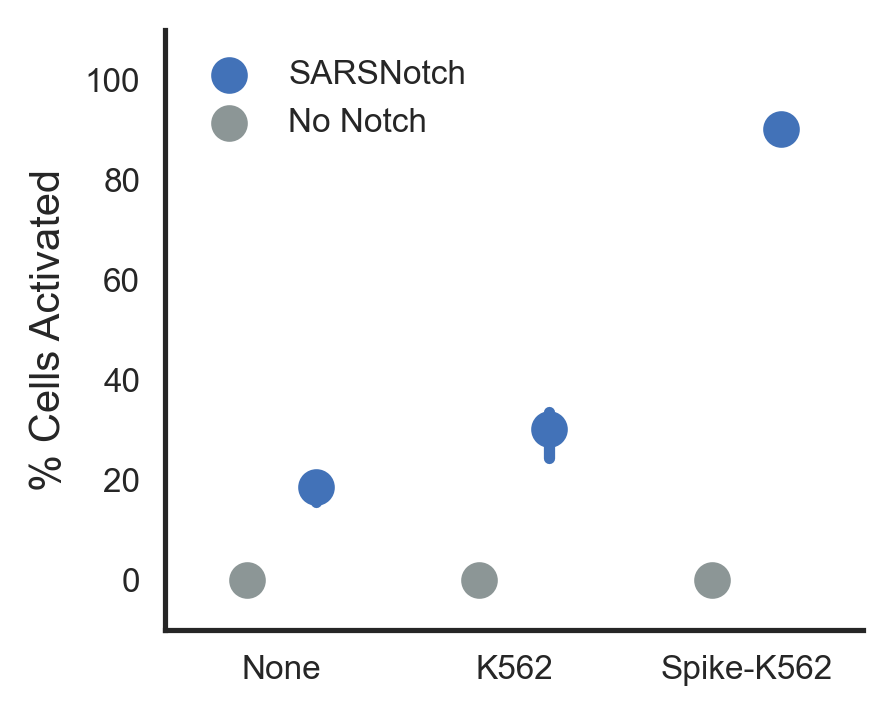

In [28]:
with sns.color_palette(['#8C9696','#4272B8', ]):
    fig, ax = plt.subplots(1,1, figsize=(3, 2.65),dpi=300)
    g = sns.pointplot(data=summary, x='Sender', y='logBV 421-A', order=['None', 'K562', 'Spike-K562'],
                      hue='Receiver', hue_order=['No Notch', 'SARSNotch'], 
                      dodge=0.3, join=False, ax=ax, markersize=10)
    g.legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='upper left')
    g.set_xlabel('')
    g.set_ylabel('% Cells Activated')
    plt.ylim([-10,110])
    sns.despine()
    plt.savefig(outputdir + 'bhk_cell_response.svg')

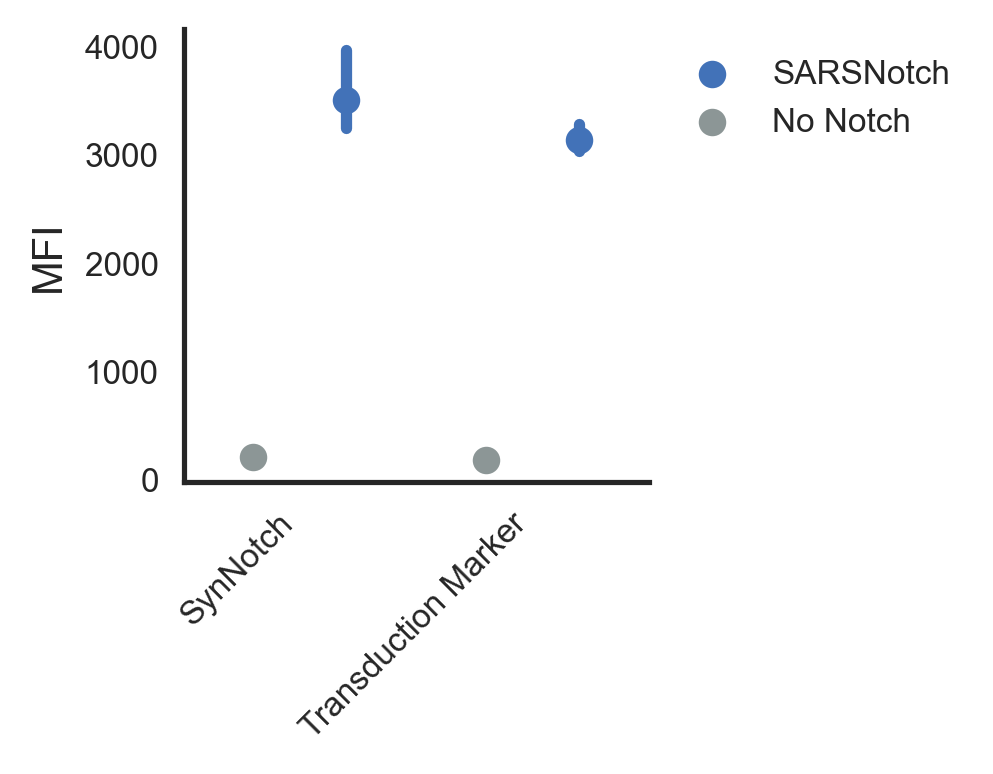

In [33]:
simplified_df = (df2[df2['logFITC-A'] > 5]
                 .reset_index()
                 .melt(value_vars=['PE-CF594-A','APC-A'], 
                       id_vars=['index','Receiver','Sender','Dose','Replicate'],
                       var_name='channel',
                       value_name='counts')
                 .reset_index()
                 .groupby(['Receiver','Sender','Dose','Replicate', 'channel'])['counts']
                 .mean()
                 .reset_index())

simplified_df.loc[simplified_df['channel'] == 'PE-CF594-A', 'channel'] = 'Transduction Marker'
simplified_df.loc[simplified_df['channel'] == 'APC-A', 'channel'] = 'SynNotch'

with sns.color_palette(['#8C9696','#4272B8']):
    fig, ax = plt.subplots(1,1,figsize=(2,2),dpi=300)
    g = sns.pointplot(data=simplified_df[(simplified_df['Dose']=='0') &
                                         (simplified_df['Receiver'].isin(['No Notch','SARSNotch'])) &
                                         (simplified_df['Sender'] == 'None')], 
                      x='channel', y='counts', hue='Receiver', join=False, dodge=0.4,
                      hue_order=['No Notch', 'SARSNotch'], scale=0.75)
    g.legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='upper left', bbox_to_anchor=[1,1])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('MFI')
    sns.despine()
    plt.savefig(outputdir + 'mfi_bhks.svg')

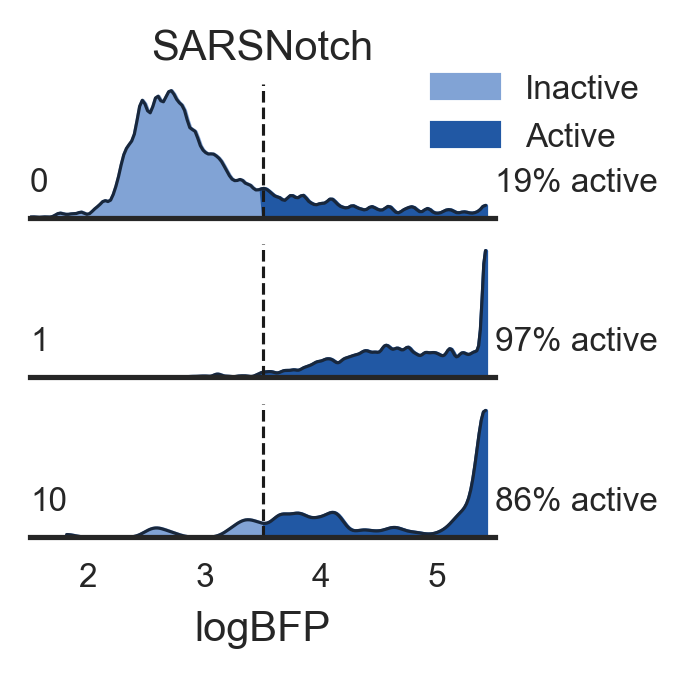

In [43]:
qt=3.5
fig, axs = plt.subplots(3,1,figsize=(2,2), dpi=300)

for dose, ax in zip(['0', '1', '10'], axs):
    subset = df2[(df2['Receiver'] == 'SARSNotch') &
             (df2['Dose'] == dose)].copy()
    active = np.sum(subset['logBV 421-A'] > qt)/len(subset)
    sns.kdeplot(data=subset, x='logBV 421-A', shade=False, ax=ax, color='#18273C', cut=0, bw_adjust=0.2, lw=0.76)
    kde_x, kde_y = ax.lines[0].get_data()
    ax.fill_between(kde_x, kde_y, where=(kde_x<qt) , 
                interpolate=True, color='#81A3D5', label='Inactive')
    ax.fill_between(kde_x, kde_y, where=(kde_x>qt) , 
                interpolate=True, color='#2158A4', label='Active')
    ax.axvline(qt, c='k', ls='--', lw=0.75)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set(facecolor=(0, 0, 0, 0))
    ax.text(0, 0.2, dose, transform=ax.transAxes)
    ax.text(1, 0.2, f'{active*100:.0f}% active', transform=ax.transAxes)
    ax.set_xlim([1.5, 5.5])

plt.xlabel('logBFP')
axs[0].legend(frameon=False, loc='upper left', bbox_to_anchor=[0.8,1.3])
axs[0].set_title('SARSNotch')
for idx in [0,1]:
    axs[idx].set_xticks([])
    axs[idx].set_xlabel('')
sns.despine(left=True)
plt.savefig(outputdir + 'sample_arbitrary_quant_sarsnotch.svg')